#### Stock Market Prediction And Forecasting Using Stacked LSTM

In [122]:
import api_key
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [123]:
key = api_key.api_key

In [124]:
import pandas_datareader as pdr
df = pdr.get_data_tiingo('AAPL', api_key = key)
# df.to_csv('AAPL.csv')

In [125]:
# df = pd.read_csv('AAPL.csv')
df.reset_index(inplace = True)

In [126]:
df.drop('symbol', axis = 1, inplace = True)

In [127]:
df = df[['close','date']]
df.loc[:,'date'] = df['date'].apply(lambda x: x.date())

In [176]:
df.head()

,close,date
0,0.015201,2016-01-19
1,0.015514,2016-01-20
2,0.014336,2016-01-21
3,0.026651,2016-01-22
4,0.021888,2016-01-25


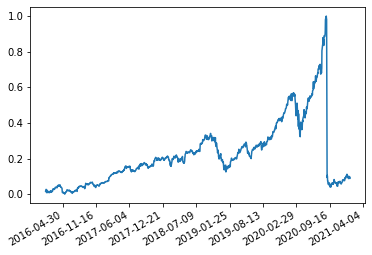

In [177]:
plt.figure()
ax = plt.gca()
formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.DayLocator(interval=200)
ax.xaxis.set_major_locator(locator)
plt.plot(df.date, df['close'])
plt.gcf().autofmt_xdate()
plt.show()

### LSTM is sensitive to the scale of data, so we apply MinMax Scaler

In [178]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df['close'] = pd.DataFrame(scaler.fit_transform(np.array(df['close']).reshape(-1,1)))

In [179]:
## Splitting dataset into train and test split
train_size = 0.65
train_index = int((df['close'].shape[0] * train_size)//1)
train_data = df.loc[:train_index-1,:]
test_data = df.loc[train_index:,:]
assert df.shape[0] == (train_data.shape[0] + test_data.shape[0])

In [180]:
def create_dataset(dataset: pd.Series, time_step = 1) -> (np.array, np.array):
    data = dataset.values
    # time_step = 3
    dataset_length = data.shape[0]
    X_data = list()
    y_data = list()
    for index in range(0, dataset_length - time_step):
        X_data.append((data[index:index+time_step]))
        y_data.append(data[index+time_step])
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return(X_data, y_data)

In [181]:
time_step = 100
X_train, y_train = create_dataset(train_data['close'], time_step)
X_test, y_test = create_dataset(test_data['close'], time_step)
X_train.shape, y_train.shape

((718, 100), (718,))

In [182]:
X_train.shape, y_train.shape

((718, 100), (718,))

In [183]:
X_test.shape, y_test.shape

((341, 100), (341,))

In [189]:
X_train.shape

(718, 100)

In [190]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [191]:
# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [196]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [197]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [198]:
model.fit(X_train,y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
12/12 [==============================] - 3s 274ms/step - loss: 0.0063 - val_loss: 0.0517
Epoch 2/100
12/12 [==============================] - 2s 151ms/step - loss: 0.0016 - val_loss: 0.0244
Epoch 3/100
12/12 [==============================] - 1s 108ms/step - loss: 6.4327e-04 - val_loss: 0.0201
Epoch 4/100
12/12 [==============================] - 2s 137ms/step - loss: 3.7754e-04 - val_loss: 0.0196
Epoch 5/100
12/12 [==============================] - 1s 107ms/step - loss: 3.5908e-04 - val_loss: 0.0192
Epoch 6/100
12/12 [==============================] - 1s 107ms/step - loss: 3.4483e-04 - val_loss: 0.0187
Epoch 7/100
12/12 [==============================] - 1s 108ms/step - loss: 3.2578e-04 - val_loss: 0.0181
Epoch 8/100
12/12 [==============================] - 1s 108ms/step - loss: 3.2009e-04 - val_loss: 0.0176
Epoch 9/100
12/12 [==============================] - 1s 108ms/step - loss: 3.0791e-04 - val_loss: 0.0172
Epoch 10/100
12/12 [==============================] - 1s 111ms/

In [199]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict.shape

(718, 1)

In [200]:
## Transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [202]:
## Calculating RMSE performance metrics 
import math
from sklearn.metrics import mean_squared_error
print(f"Train data RMSE: {math.sqrt(mean_squared_error(y_train, train_predict))}")
print(f"Test data RMSE: {math.sqrt(mean_squared_error(y_test, test_predict))}")

Train data RMSE: 0.010177997646851778
Test data RMSE: 0.08343761670980618


In [207]:
X_train

array([[[0.01520144],
        [0.01551413],
        [0.01433554],
        ...,
        [0.02090198],
        [0.02068551],
        [0.02239327]],

       [[0.01551413],
        [0.01433554],
        [0.02665063],
        ...,
        [0.02068551],
        [0.02239327],
        [0.02042093]],

       [[0.01433554],
        [0.02665063],
        [0.02188815],
        ...,
        [0.02239327],
        [0.02042093],
        [0.01683704]],

       ...,

       [[0.24820204],
        [0.22975346],
        [0.20839447],
        ...,
        [0.26525556],
        [0.26123873],
        [0.2610463 ]],

       [[0.22975346],
        [0.20839447],
        [0.20791341],
        ...,
        [0.26123873],
        [0.2610463 ],
        [0.26191221]],

       [[0.20839447],
        [0.20791341],
        [0.19711365],
        ...,
        [0.2610463 ],
        [0.26191221],
        [0.26196031]]])